Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [130]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [141]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

#filename = maybe_download('text8.zip', 31344016)
filename = 'sztp_ekezet_nelkul.txt.zip'

Read the data into a string.

A `tf.compat.as_str()` -ről tényleg nincs doksi??

In [142]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

# megértéshez
#words = ['Most', 'jo', 'ez', ',', 'vagy', 'nem', 'jo', '?']

Data size 65128


In [143]:
print(words[0:100])

['MIKSZATH', 'KALMAN', 'SZENT', 'PETER', 'ESERNYOJE', 'TARTALOM', 'ELSO', 'RESZ', 'A', 'LEGENDA', 'VISZIK', 'A', 'KIS', 'VERONKAT', 'GLOGOVA', 'REGEN', 'AZ', 'UJ', 'PAP', 'GLOGOVAN', 'AZ', 'ESERNYO', 'ES', 'SZENT', 'PETER', 'MASODIK', 'RESZ', 'A', 'GREGORICSOK', 'A', 'TAPINTATLAN', 'GREGORICS', 'GYANUS', 'JELENSEGEK', 'GREGORICS', 'PAL', 'HALALA', 'ES', 'HAGYATEKA', 'A', 'KAPZSI', 'GREGORICSOK', 'HARMADIK', 'RESZ', 'A', 'NYOMOK', 'AZ', 'ESERNYO', 'KIBUKKAN', 'A', 'MI', 'ROZALINK', 'A', 'SZALAK', 'GLOGOVARA', 'VEZETNEK', 'A', 'FULBEVALO', 'NEGYEDIK', 'RESZ', 'A', 'BABASZEKI', 'INTELLIGENCIA', 'VACSORA', 'MRAVUCSANEKNAL', 'AZ', 'EJ', 'TANACSOT', 'AD', 'OTODIK', 'RESZ', 'A', 'HARMADIK', 'ORDOG', 'A', 'CZOBOR', 'MARIA', 'ROZSAJA', ',', 'A', 'FOLDHASADEK', 'ES', 'A', 'VEN', 'KORTEFA', 'HAROM', 'USZOG', 'VISZIK', 'A', 'KIS', 'VERONKAT', '__________________________________________________________________', 'ELSO', 'RESZ', 'A', 'LEGENDA', 'VISZIK', 'A', 'KIS', 'VERONKAT']


Build the dictionary and replace rare (= not in most frequent `vocabulary_size`) words with UNK token.

In [144]:
vocabulary_size = 10000
#vocabulary_size = 50000 # ekkor a szpt.txt-re KeyError hibát ad, vajon miért?

def build_dataset(words):
    count = [['UNK', -1]] # sztem [('UNK', -1)] kéne... azzal hogy lenne?
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1)) # ez megszámolja!
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary) # ó, ez adja az azonosítót :)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index) # itt szórjuk ki a "ritka" szavakat vocabulary_size alapján
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
# data = szavak sorban a dictionary-s indexükkel repr
# count = szó -> előfordulási szám
# dictionary = szó -> azonosító
# reverse_dictionary azonosító -> szó (2 külön adatszerk, ez tetszik!)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 5793], (',', 6765), ('a', 3995), ('.', 3588), ('-', 1696)]
Sample data [0, 0, 2444, 1784, 9069, 5586, 3848, 564, 14, 2695]


In [145]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print(data[0:10])
print(count[0:10])
print(take(10, dictionary.iteritems()))
print(take(10, reverse_dictionary.iteritems()))

[0, 0, 2444, 1784, 9069, 5586, 3848, 564, 14, 2695]
[['UNK', 5793], (',', 6765), ('a', 3995), ('.', 3588), ('-', 1696), ('az', 1460), ('hogy', 758), ('nem', 647), ('is', 647), ('?', 573)]
[('tanitone', 4444), ('kiitta', 4445), ('hazigazdat', 4446), ('hamisnak', 4447), ('maradna', 4529), ('finomabbnal', 4450), ('allami', 4451), ('legkedvesebb', 4452), ('jegverestol', 4453), ('eroskodek', 4454)]
[(0, 'UNK'), (1, ','), (2, 'a'), (3, '.'), (4, '-'), (5, 'az'), (6, 'hogy'), (7, 'nem'), (8, 'is'), (9, '?')]


Function to generate a training batch for the skip-gram model.

In [146]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window): # XXX mi a fenét csinál? mi a 3 param???
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

# csak debug / bemutatás
for num_skips, skip_window in [(1, 1), (2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['UNK', 'UNK', 'SZENT', 'PETER', 'ESERNYOJE', 'TARTALOM', 'ELSO', 'RESZ']

with num_skips = 1 and skip_window = 1:
    batch: ['UNK', 'SZENT', 'PETER', 'ESERNYOJE', 'TARTALOM', 'ELSO', 'RESZ', 'A']
    labels: ['UNK', 'UNK', 'SZENT', 'PETER', 'ELSO', 'RESZ', 'ELSO', 'LEGENDA']

with num_skips = 2 and skip_window = 1:
    batch: ['UNK', 'UNK', 'SZENT', 'SZENT', 'PETER', 'PETER', 'ESERNYOJE', 'ESERNYOJE']
    labels: ['UNK', 'SZENT', 'PETER', 'UNK', 'SZENT', 'ESERNYOJE', 'PETER', 'TARTALOM']

with num_skips = 4 and skip_window = 2:
    batch: ['SZENT', 'SZENT', 'SZENT', 'SZENT', 'PETER', 'PETER', 'PETER', 'PETER']
    labels: ['PETER', 'UNK', 'ESERNYOJE', 'UNK', 'ESERNYOJE', 'TARTALOM', 'SZENT', 'UNK']


Train a skip-gram model.

In [147]:
batch_size = 128

embedding_size = 128 # Dimension of the embedding vector.

skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label. -- még mindig nem vili! XXX

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 8 # Random set of words to evaluate similarity on.
#valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'): # XXX gpu?

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset) # XXX na ez mit csinál?

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))
    # XXX ez mit csinál?
    # XXX ez hogy viszonyul a softmax_cross_entropy_with_logits()-hoz?

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    #
    # XXX elvben oké, de ez hogy is volt eddig?
    #
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance: (= először normalizálás, aztán összeszorzás!)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [148]:
num_steps = 100001

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')

    average_loss = 0

    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
        average_loss += l

        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1] # XXX húha, mi is ez? :)
                log = ' Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 4.461231
 Nearest to se: mormogja, osszeallitani, sajat, bes, kartyan, varban, falakbol, >>safranyikok<<,
 Nearest to fel: ravasz, megtudtam, szekre, gyon, keveset, reszt, hasadekbol, l,
 Nearest to ket: emlekezik, -, magankivul, (, emtett, ablakaival, Azonnal, asztalara,
 Nearest to ra: sorait:, erdon, Sranko, kornyekbeli, valasz, mondana:, erteni, sogortol,
 Nearest to ,: lefekudt, igenyei, tanyerok, gondosan, tagloval, kicsiny, intrikus, szolok,
 Nearest to olyan: geged, amelyikben, kovacs, elerzekenyult, punktum, csendesen, elfogadni, Altalanos,
 Nearest to mint: szuz, vizbe, szeretojenek, Ah, tajtekozva, kozti, folfele, hordora,
 Nearest to de: O, megborotvalta, bebutorozta, raigert, tedd, gyavasagot, Szentivanyit, ertette,
Average loss at step 2000: 3.774819
Average loss at step 4000: 3.123127
Average loss at step 6000: 2.833736
Average loss at step 8000: 2.655175
Average loss at step 10000: 2.537606
 Nearest to se: mormogja, osszeallitani, fal

In [149]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

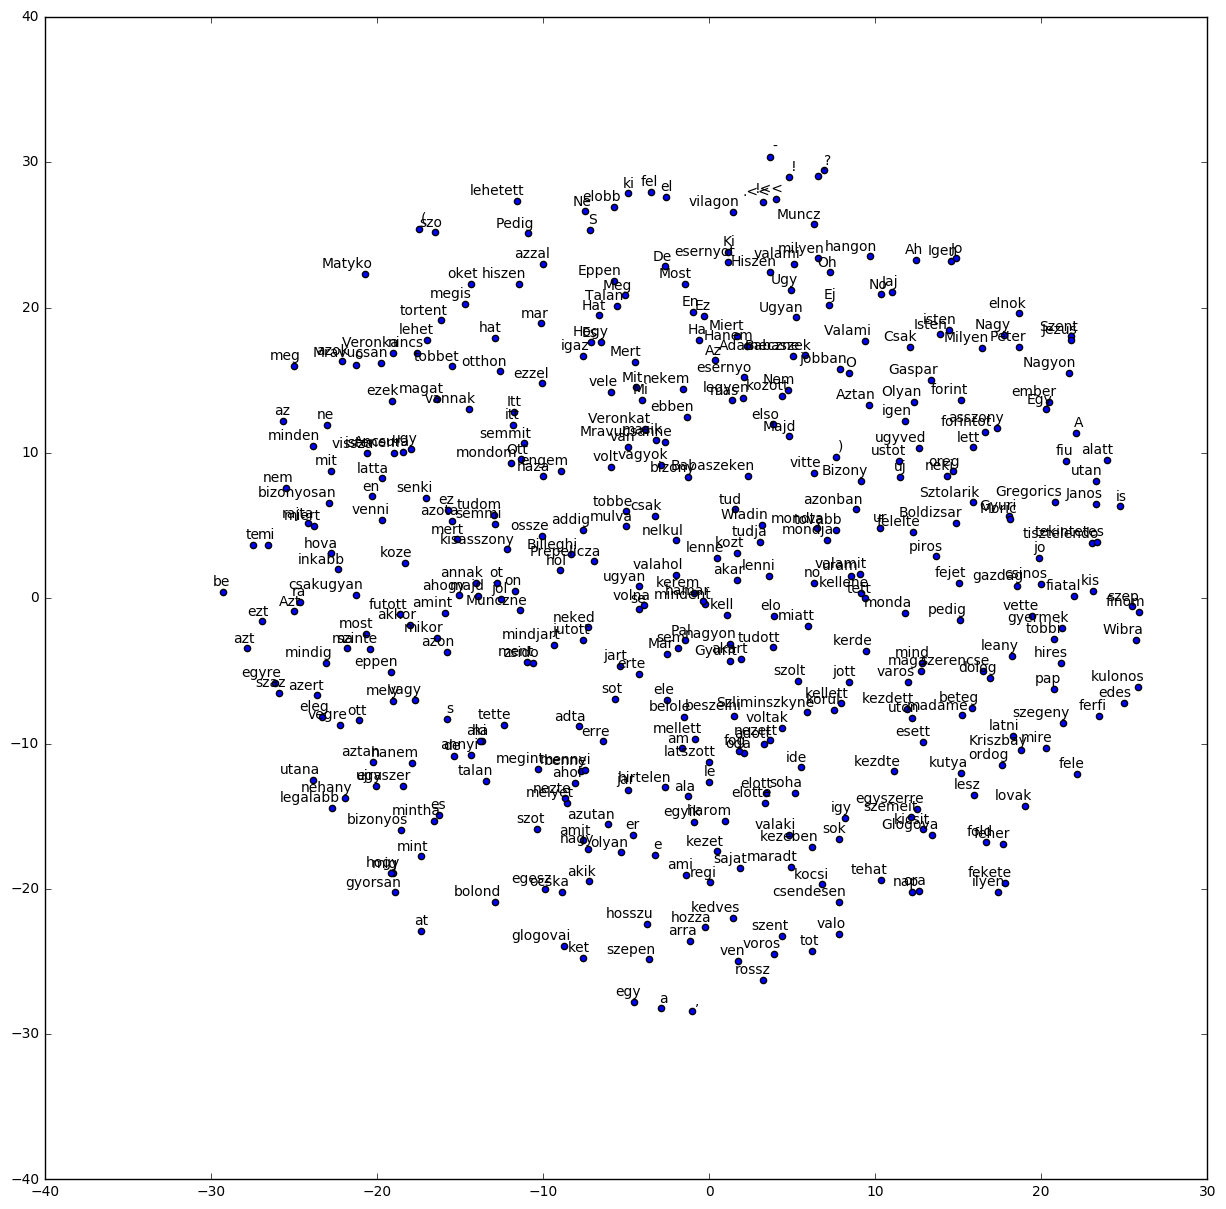

In [150]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

**Vhogy ki kell fordítani, gondolom. :)**

---